# Importing packages

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Function definitions

In [2]:
years = ["1996","1998","2000","2002","2004","2006","2008","2010","2012","2014","2016","2018"]
comSymList = ["Apple","Amazon","Microsoft","Facebook"]
allSymList = ["S&P500","Apple","Amazon","Microsoft","Facebook"]

def hurst_rs(ts, minChunkSize:int, maxChunkSize:int, numChunkSize:int) -> float:
    """
    Estimate the Hurst exponent using R/S (rescaled range) method from the time series.
    
    Parameters
    ----------
    ts : np.ndarray float
        A time series for calculating the hurst exponent.
    minChunkSize : int
        The minimum window size.
    maxChunkSize : int
        The maximum window size.
    numChunkSize : int
        The size of the step from minimum to maximum window size. 
        Bigger step means fewer calculations.

    Returns
    -------
    H : float
        A estimation of Hurst exponent.
    """

    tsSize = len(ts)
    maxChunkSize += 1
    temp = np.empty(tsSize, dtype=np.float64)
    chunkSizeList = np.linspace(minChunkSize, maxChunkSize, numChunkSize).astype(np.int64)
    tsValuesWindow = np.empty(numChunkSize, dtype=np.float64)

    for i in range(numChunkSize):
        chunkSize = chunkSizeList[i]

        numChunks = int(tsSize / chunkSize)

        for idx in range(numChunks):
            ini = idx * chunkSize
            end = ini + chunkSize
            chunk = ts[ini:end]

            z = np.cumsum(chunk - np.mean(chunk))
            temp[idx] = np.divide(
                np.max(z) - np.min(z),
                np.nanstd(chunk)
            )

        tsValuesWindow[i] = np.nanmean(temp[:idx + 1])

    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunkSizeList), np.ones(numChunkSize))).T,
        b=np.log(tsValuesWindow),
        rcond = None
    )[0]
    
    return H

def hurst_exponent(prices, minChunkSize: int =8, maxChunkSize: int =100, numChunkSize: int =5) -> float:
    """
    Estimate the Hurst exponent with case checking.

    Parameters
    ----------
    prices : np.ndarray or pd.DataFrame
        A time series for calculating the hurst exponent.
    minChunkSize : int, optional
        The minimum window size.
    maxChunkSize : int, optional
        The maximum window size.
    numChunkSize : int, optional
        The size of the step from minimum to maximum window size. 
        Bigger step means fewer calculations.

    Returns
    -------
    H : float
        A estimation of Hurst exponent.
    """
    if len(prices) == 0:
        return np.nan
    arr = prices.__array__()
    
    if prices.ndim > 1:
            H = hurst_rs(np.diff(arr, axis=0).T, minChunkSize, maxChunkSize,
                         numChunkSize)
    else:
            H = hurst_rs(np.diff(arr), minChunkSize, maxChunkSize,
                         numChunkSize)
    return H

def plot_com(prices: pd.DataFrame):
    """
    Plotting the price series of four companies.

    Parameters
    ----------
    prices : pd.DataFrame
        The DataFrame of the four companies for calculating the hurst exponent.
        
    Returns
    -------
    A 2x2 plot of close price of the four companies chosen.
    """

    kw = dict(figsize=(16,8), grid=True, subplots=True, layout=(2,2), linewidth=0.75)
    axs = prices.plot(**kw)

    for ax in axs.flat[::2]:
        ax.set_ylabel('In dollars ($)')
    
    plt.suptitle('Close Price by Company', y=0.95);

def plot_day_avg(rollHurst, numDays:int = 50):
    """
    Plotting the Hurst exponent of averaged price over number 
    of days of four companies.

    Parameters
    ----------
    rollHurst : pd.DataFrame
        The Hurst exponent dataframe of the number of days average.
    numDays: int
        The number of day to take average
        
    Returns
    -------
    A 2x2 plot of Hurst exponent of the four companies chosen.
    """
    
    fig, axs = plt.subplots(2,2, figsize=(15,8))

    for ax, com in zip(axs.flat, comSymList):
        rollHurst[com][::numDays].plot(ax=ax)
        ax.set_title(com)
        ax.set_yticks(np.arange(11)/10)
        ax.grid(True, linestyle='--')
        ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
    
    fig.set_tight_layout(True)
    
def plot_day_avg_single(rollHurst, comSym:str, numDays: int = 50):
    """
    Plotting the Hurst exponent of averaged price over number 
    of days of a chosen company.

    Parameters
    ----------
    rollHurst: pd.DataFrame
        The Hurst exponent dataframe of the number of days average.

    comSym: str
        The name of the company/index chosen to look at.

    numDays: int
        The number of day to take average.
        
    Returns
    -------
    A plot of Hurst exponent of the chosen company/index.
    """
    fig = plt.figure()

    plt.plot(figsize = (15,8))
    rollHurst[comSym][::numDays].plot()
    plt.title(comSym)
    plt.yticks(np.arange(11)/10)
    plt.grid(True, linestyle='--')
    plt.axhline(0.5, linestyle='--', color='k', alpha=0.5)

    fig.set_tight_layout(True)
        
def plot_rolling_avg(rollHurst, rollDays: int = 50):
    """
    Plotting the Hurst exponent of averaged price over number 
    of days of rolling window of the four chosen company.

    Parameters
    ----------
    rollHurst: pd.DataFrame
        The Hurst exponent dataframe of the number of days average.

    rollDays: int
        The size of the rolling window.
        
    Returns
    -------
    A 2x2 plot of Hurst exponent of the four companies chosen.
    """
    fig, axs = plt.subplots(2,2, figsize=(15,8))

    for ax, com in zip(axs.flat, comSymList):
        rollHurst[com].rolling(rollDays).mean().plot(ax=ax)
        ax.set_title(com)
        ax.set_yticks(np.arange(11)/10)
        ax.grid(True, linestyle='--')
        ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
    
    fig.set_tight_layout(True)
    
def plot_rolling_avg_single(rollHurst, comSym:str, rollDays: int = 50):
    """
    Plotting the Hurst exponent of averaged price over number 
    of days of rolling window of a chosen company.

    Parameters
    ----------
    rollHurst: pd.DataFrame
        The Hurst exponent dataframe of the number of days average.

    comSym: str
        The name of the company/index chosen to look at.

    rollDays: int
        The size of the rolling window.
        
    Returns
    -------
    A plot of Hurst exponent of the chosen company/index.
    """
    fig = plt.figure()

    plt.plot(figsize = (15,8))
    rollHurst[comSym].rolling(rollDays).mean().plot()

    plt.title(comSym)
    plt.yticks(np.arange(11)/10)
    plt.grid(True, linestyle='--')
    plt.axhline(0.5, linestyle='--', color='k', alpha=0.5)
    fig.set_tight_layout(True)

def plot_hurst_over_years(df, comName: str = ""):
    """
    Plotting the Hurst Exponent without averaging nor rolling
    window of a single chosen company.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame of the chosen company/index for 
        calculating the hurst exponent.
    comName: str
        The name of the chosen company/index.
        
    Returns
    -------
    A plot of Hurst Exponent of the chosen company/index.
    """
    customDF = []

    for year in years:
        customDF.append(df.loc["1988":year])

    customDF = pd.concat(customDF, axis = 1)
    customDF.columns = years

    hurstExp = customDF.apply(lambda x: hurst_exponent(x.dropna()))
    hurstExp = pd.concat([hurstExp], axis = 1)
    hurstExp.columns = [comName + " Hurst Exponent"]
    hurstExp.plot()

# Data clean-up:

In [3]:
# Data read-in
spxDF = pd.read_csv("spx.csv")
nameVal = ["Date","Close"]
aaplDF = pd.read_table("aapl.txt", sep = ',')[nameVal]
amznDF = pd.read_table("amzn.txt", sep = ',')[nameVal]
msftDF = pd.read_table("msft.txt", sep = ',')[nameVal]
fbDF = pd.read_table("fb.txt", sep = ',')[nameVal]
companies = []

# Set the datetime of the dataframe to correct format with indicies being dates
for df in [aaplDF,amznDF,msftDF,fbDF,spxDF]:
    df.columns = nameVal
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace = True)
    
# Combining the companies series to a dataframe
comList = [aaplDF,amznDF,msftDF,fbDF]
allList = [spxDF,aaplDF,amznDF,msftDF,fbDF]
companies = pd.concat(comList, axis = 1)
allCom = pd.concat(allList, axis = 1)
companies.columns = comSymList
allCom.columns = allSymList

# Setting values to NAN if they are 0 for both dataframes and
# getting the data to a specific time frames for comparison later on
start = "2012"
end = "2017"
companies = companies.where(companies != 0., np.nan)
companies = companies.loc[start:end]
allCom = allCom.where(allCom != 0., np.nan)
allCom = allCom.loc[start:end]

# Visualizations

<AxesSubplot:xlabel='Date'>

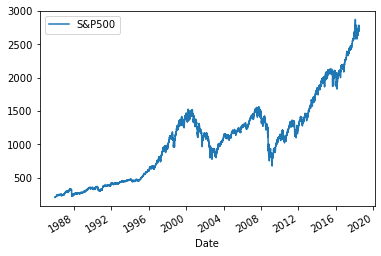

In [4]:
spxDF.columns = ["S&P500"]
spxDF.plot()

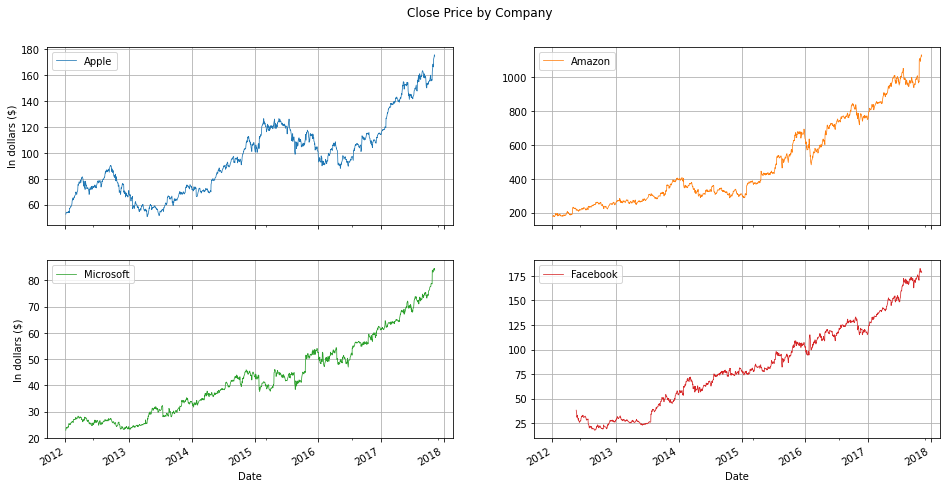

In [5]:
plot_com(companies)

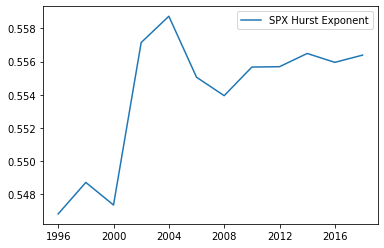

In [6]:
plot_hurst_over_years(spxDF, "SPX")

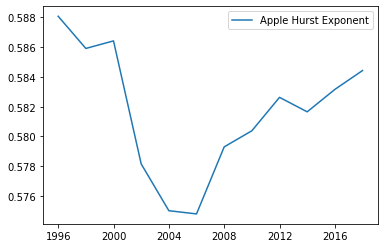

In [7]:
plot_hurst_over_years(aaplDF, "Apple")

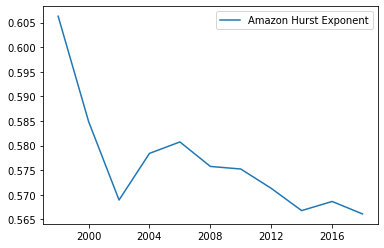

In [8]:
plot_hurst_over_years(amznDF, "Amazon")

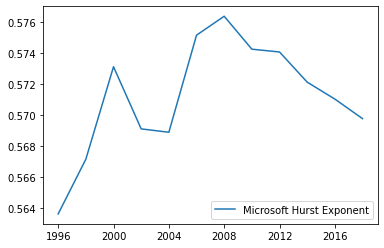

In [9]:
plot_hurst_over_years(msftDF, "Microsoft")

In [10]:
hurstExp = allCom.apply(lambda x: hurst_exponent(x.dropna()))
hurstExp = pd.concat([hurstExp], axis = 1)
hurstExp.columns = ["Hurst Exponent"]
hurstExp

,Hurst Exponent
S&P500,0.557201
Apple,0.592904
Amazon,0.560250
Microsoft,0.539048
Facebook,0.582192


In [11]:
rollDays = 250
rollPrices = allCom.rolling(250)
rollHurst = rollPrices.apply(lambda s: hurst_exponent(s),raw = False).dropna()
rollHurst[::100].head()

,S&P500,Apple,Amazon,Microsoft,Facebook
Date,,,,,
2013-05-17,0.487676,0.474797,0.509512,0.460543,0.585289
2013-10-09,0.587107,0.556741,0.551898,0.501372,0.596528
2014-03-05,0.565753,0.598159,0.533761,0.504886,0.600069
2014-07-28,0.545887,0.566838,0.499496,0.492338,0.595144
2014-12-17,0.581322,0.507111,0.514468,0.542874,0.519883


In [12]:
rollHurst[::100].mean()

S&P500       0.557902
Apple        0.580294
Amazon       0.552062
Microsoft    0.523684
Facebook     0.569275
dtype: float64

In [13]:
rollHurst[::50].mean()

S&P500       0.563955
Apple        0.593804
Amazon       0.554723
Microsoft    0.525269
Facebook     0.565725
dtype: float64

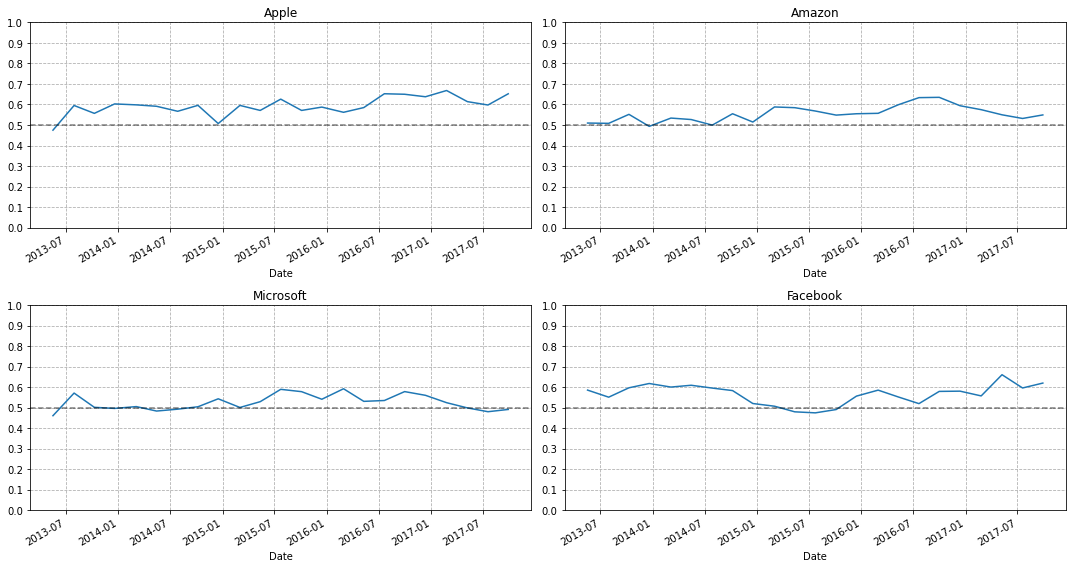

In [14]:
plot_day_avg(rollHurst)

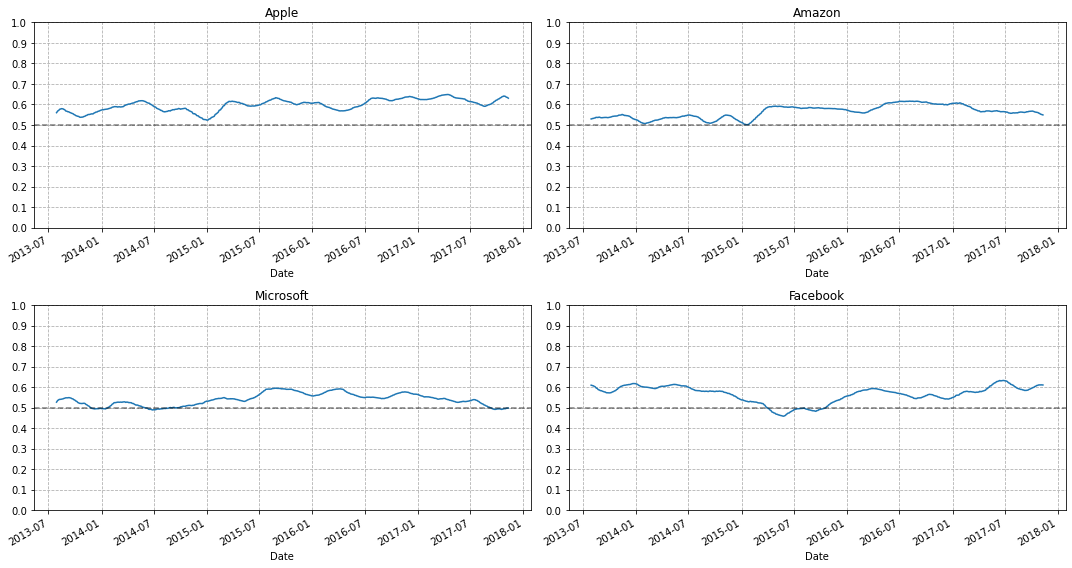

In [15]:
plot_rolling_avg(rollHurst)

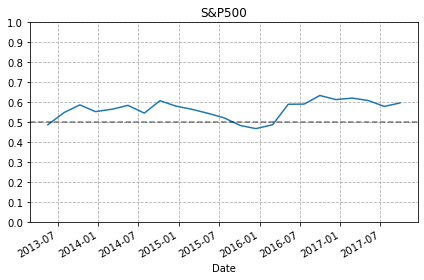

In [16]:
plot_day_avg_single(rollHurst, "S&P500")

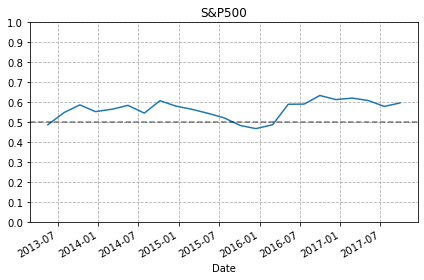

In [17]:
plot_day_avg_single(rollHurst, "S&P500")